In [1]:
pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 1: Imports & warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Qiskit imports (AerSimulator is in qiskit-aer package)
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace

from qiskit.circuit import Parameter

from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")


Train size: (120, 2) Test size: (40, 2)


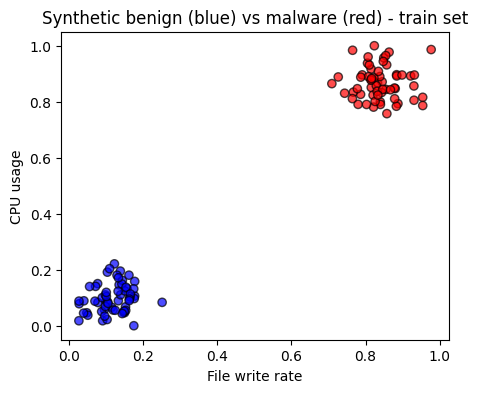

In [3]:
# Cell 2: Create synthetic dataset (2 features) and show train scatter
rng = np.random.default_rng(42)
benign = rng.normal(loc=[0.2, 0.2], scale=0.05, size=(80, 2))
malware = rng.normal(loc=[0.8, 0.8], scale=0.05, size=(80, 2))
X = np.vstack([benign, malware])
y = np.hstack([np.zeros(len(benign)), np.ones(len(malware))])

# Clip to [0,1]
X = np.clip(X, 0, 1)

# Optional normalization - already in [0,1] roughly; keep for generality
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42, stratify=y)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

plt.figure(figsize=(5,4))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='bwr', edgecolors='k', alpha=0.7)
plt.xlabel("File write rate")
plt.ylabel("CPU usage")
plt.title("Synthetic benign (blue) vs malware (red) - train set")
plt.show()


Parameterized circuit (symbolic parameters):


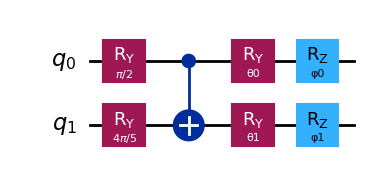

In [4]:
# Cell 3: Build a parameterized 2-qubit circuit (angle encoding + variational layer)
# Parameter symbols for the variational layer
theta0 = Parameter('θ0')
phi0 = Parameter('φ0')
theta1 = Parameter('θ1')
phi1 = Parameter('φ1')

def build_parametric_circuit(x):
    """
    Returns a QuantumCircuit with symbolic parameters (theta0,phi0,theta1,phi1)
    where x is a 2-element feature vector (each in [0,1]).
    """
    qc = QuantumCircuit(2)
    # Data encoding: map feature in [0,1] -> angle in [0, pi] via RY
    qc.ry(x[0] * np.pi, 0)
    qc.ry(x[1] * np.pi, 1)
    # Entangling gate
    qc.cx(0, 1)
    # Variational (trainable) single-qubit rotations (symbolic)
    qc.ry(theta0, 0)
    qc.rz(phi0, 0)
    qc.ry(theta1, 1)
    qc.rz(phi1, 1)
    return qc

# Example circuit (symbolic) for the mid-presentation screenshot
example_x = [0.5, 0.8]
qc_example = build_parametric_circuit(example_x)
print("Parameterized circuit (symbolic parameters):")
display(qc_example.draw('mpl'))


In [5]:
# Cell 4: Simulator and expectation helpers
sim = AerSimulator(method="statevector")

def expectation_per_qubit_from_statevector(statevec):
    """
    Given a statevector (1D complex np.array), compute expectation <Z> for each qubit.
    Works for small n_qubits (here n=2).
    """
    sv = Statevector(statevec)
    n = int(np.log2(len(statevec)))
    exps = []
    # Compute reduced density matrix for each qubit and then expectation Tr(rho * Z)
    dm = DensityMatrix(sv)
    for qubit in range(n):
        # partial_trace over other qubits to isolate this qubit
        rho_q = partial_trace(dm, [i for i in range(n) if i != qubit])
        # Pauli-Z operator
        pauli_z = np.array([[1.0, 0.0], [0.0, -1.0]])
        exp_val = np.trace(rho_q.data @ pauli_z).real
        exps.append(float(exp_val))
    return np.array(exps)

def circuit_expectations_for_params(x, param_values):
    """
    Bind the variational parameters (θ0,φ0,θ1,φ1) and run the statevector simulator,
    returning list of expectation values <Z> for each qubit.
    param_values should be a list/array of length 4.
    """
    qc = build_parametric_circuit(x)
    bind_dict = {
        theta0: param_values[0],
        phi0: param_values[1],
        theta1: param_values[2],
        phi1: param_values[3]
    }
    qc_bound = qc.assign_parameters(bind_dict)

    # Tell simulator to save statevector
    qc_sv = qc_bound.copy()
    qc_sv.save_statevector()

    # Transpile & run
    tcirc = transpile(qc_sv, sim)
    result = sim.run(tcirc).result()

    # Extract statevector
    sv = result.get_statevector()
    exps = expectation_per_qubit_from_statevector(sv)
    return exps


In [6]:
# Cell 5: Model score function (continuous output) and small debug print
def model_score_for_sample(x, params):
    exps = circuit_expectations_for_params(x, params)
    score = np.tanh(np.sum(exps))   # continuous in (-1,1)
    return float(score)

# Debug: sample expectations with random params
rand_params = np.random.normal(0, 0.1, size=4)
print("Random params:", np.round(rand_params,3))
for i in range(4):
    e = circuit_expectations_for_params(X_train[i], rand_params)
    print(f"sample {i} exps: {np.round(e,3)} score: {np.round(model_score_for_sample(X_train[i], rand_params),3)}")


Random params: [ 0.047 -0.056  0.195  0.048]
sample 0 exps: [0.958 0.93 ] score: 0.955
sample 1 exps: [0.987 0.932] score: 0.958
sample 2 exps: [0.986 0.939] score: 0.958
sample 3 exps: [0.908 0.808] score: 0.937


In [7]:
# Cell 6: Loss function for optimization (MSE against signed labels)
y_train_signed = 2*y_train - 1  # convert labels 0->-1, 1->+1

def loss_for_params(params_vector, X_data, y_signed):
    preds = np.array([model_score_for_sample(x, params_vector) for x in X_data])
    loss = np.mean((y_signed - preds)**2)
    return float(loss)

# Print initial loss with a random start
init_params = np.random.normal(0, 0.1, size=4)
print("Initial loss (random init):", loss_for_params(init_params, X_train, y_train_signed))


Initial loss (random init): 2.5365131202485327


In [ ]:
# Cell 7: Optimize parameters using COBYLA (gradient-free)
print("Starting COBYLA optimization (may take ~30s-2min depending on machine)...")
res = minimize(fun=loss_for_params, x0=init_params, args=(X_train, y_train_signed),
               method='COBYLA', options={'maxiter': 400, 'tol': 1e-4})
opt_params = res.x
print("Optimization success:", res.success, "| message:", res.message)
print("Optimized params:", np.round(opt_params, 4))
print("Train loss after optimization:", loss_for_params(opt_params, X_train, y_train_signed))


Starting COBYLA optimization (may take ~30s-2min depending on machine)...


In [ ]:
# Cell 8: Evaluate on test set and print predictions (for PPT screenshot)
preds_test_scores = np.array([model_score_for_sample(x, opt_params) for x in X_test])
preds_test = (preds_test_scores > 0).astype(int)
acc = accuracy_score(y_test, preds_test)
print("Quantum-variational model test accuracy:", round(acc, 4))

# Print sample predictions
print("\nSample test predictions (score, pred, true):")
for i in range(min(10, len(X_test))):
    print(f"X_test[{i}] = {np.round(X_test[i],3)}, score={preds_test_scores[i]:+.3f}, pred={preds_test[i]}, true={int(y_test[i])}")


In [ ]:
# Cell 9: Loss surface slice (visual) - vary theta0 and theta1, keep phi fixed at opt values
grid_t0 = np.linspace(opt_params[0] - 1.0, opt_params[0] + 1.0, 36)
grid_t1 = np.linspace(opt_params[2] - 1.0, opt_params[2] + 1.0, 36)
Z = np.zeros((len(grid_t0), len(grid_t1)))
for i, t0 in enumerate(grid_t0):
    for j, t1 in enumerate(grid_t1):
        pv = [t0, opt_params[1], t1, opt_params[3]]
        Z[i, j] = loss_for_params(pv, X_train, y_train_signed)

plt.figure(figsize=(6,5))
plt.contourf(grid_t0, grid_t1, Z, levels=30, cmap='viridis')
plt.scatter([opt_params[0]], [opt_params[2]], color='red', label='optimum')
plt.xlabel('theta0')
plt.ylabel('theta1')
plt.title('Loss surface slice (varying θ0, θ1)')
plt.colorbar(label='MSE loss')
plt.legend()
plt.show()


In [ ]:
# Cell 10: Decision surface visualization (for PPT)
xx, yy = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 80))
grid_scores = np.zeros_like(xx)
# Evaluate model on grid (this is the slow part; it's okay for a 80x80 grid)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        grid_scores[i, j] = model_score_for_sample([xx[i, j], yy[i, j]], opt_params)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, grid_scores, levels=30, cmap='RdBu', alpha=0.9)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='bwr', edgecolors='k')
plt.colorbar(label='model score (tanh(sum(<Z>)))')
plt.xlabel('File write rate')
plt.ylabel('CPU usage')
plt.title('Decision surface (red -> positive malware score)')
plt.show()


In [ ]:
qc_bound_example = build_parametric_circuit(example_x).assign_parameters(
    {theta0: opt_params[0], phi0: opt_params[1], theta1: opt_params[2], phi1: opt_params[3]}
)

# Save statevector before running
qc_sv = qc_bound_example.copy()
qc_sv.save_statevector()

tc = transpile(qc_sv, sim)
res = sim.run(tc).result()
sv = res.get_statevector()
plot_bloch_multivector(sv)


In [ ]:
# Cell 12: Summary print to screenshot for PPT
print("=== SUMMARY ===")
print("Optimized params (θ0, φ0, θ1, φ1):", np.round(opt_params, 4))
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])
print("Test accuracy:", round(acc, 4))
